In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 9.8 MB 15.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# **Load data**

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/longpt233/stock-trace/main/data/vndirect/all/ACB.csv?token=ANSU5LSS67NJAIFAOWWINLTBNDYEI'
#stock_data = pd.read_csv(url, index_col=0, parse_dates=[0])
stock_data = pd.read_csv(url)
stock_data.head(10)

,2013-01-02,5.168,17.3,6.135,17.3.1,2578600.0,43975750000.0,100200.0,1632964000.0,16.3,17.4,16.3.1,2678800.0
0,2013-01-03,5.078,17.0,-1.7341,17.0,1967200.0,3.379012e+10,163.0,2.624300e+06,17.5,17.8,16.7,1967363.0
1,2013-01-04,5.138,17.2,1.1765,17.1,1170100.0,1.989316e+10,95.0,1.510500e+06,16.9,17.2,16.7,1170195.0
2,2013-01-07,5.138,17.2,0.5848,17.1,1355700.0,2.333590e+10,402.0,6.432000e+06,17.0,17.5,17.0,1356102.0
3,2013-01-08,5.168,17.3,1.1696,17.1,2180000.0,3.749339e+10,418.0,6.688000e+06,17.1,17.5,16.9,2180418.0
4,2013-01-09,5.409,18.1,5.8480,18.1,3861400.0,6.945910e+10,100302.0,1.724832e+09,17.1,18.2,17.1,3961702.0
5,2013-01-10,5.468,18.3,1.1050,18.2,880700.0,1.585709e+10,226.0,3.819400e+06,18.1,18.3,17.7,880926.0
6,2013-01-11,5.437,18.2,0.0000,18.2,806200.0,1.484912e+10,61.0,1.037000e+06,19.0,19.0,18.2,806261.0
7,2013-01-14,5.377,18.0,-1.0989,18.0,614300.0,1.104665e+10,213.0,3.621000e+06,18.4,18.4,17.7,614513.0
8,2013-01-15,5.437,18.2,1.1111,324340200.0,1310500.0,2.002100e+04,20021.0,3.243402e+08,18.2,18.3,17.6,1330521.0
9,2013-01-16,5.437,18.2,0.0000,18.4,1346900.0,2.484120e+10,50124.0,9.120336e+08,18.2,18.8,18.1,1397024.0


In [ ]:
stock_data.columns= ['date', 'adjust', 'close', 'change_perc', 'avg', 'volume_match', 'value_match', 'volume_reconcile', 'value_reconcile', 'open', 'high', 'low', 'volume']

stock_data.head(5)

,date,adjust,close,change_perc,avg,volume_match,value_match,volume_reconcile,value_reconcile,open,high,low,volume
0,2013-01-03,5.078,17.0,-1.7341,17.0,1967200.0,3.379012e+10,163.0,2.624300e+06,17.5,17.8,16.7,1967363.0
1,2013-01-04,5.138,17.2,1.1765,17.1,1170100.0,1.989316e+10,95.0,1.510500e+06,16.9,17.2,16.7,1170195.0
2,2013-01-07,5.138,17.2,0.5848,17.1,1355700.0,2.333590e+10,402.0,6.432000e+06,17.0,17.5,17.0,1356102.0
3,2013-01-08,5.168,17.3,1.1696,17.1,2180000.0,3.749339e+10,418.0,6.688000e+06,17.1,17.5,16.9,2180418.0
4,2013-01-09,5.409,18.1,5.8480,18.1,3861400.0,6.945910e+10,100302.0,1.724832e+09,17.1,18.2,17.1,3961702.0


In [ ]:
#Lấy giá đóng cửa để dự đoán
close_data = stock_data[['date','close']]

close_data.head(5)

,date,close
0,2013-01-03,17.0
1,2013-01-04,17.2
2,2013-01-07,17.2
3,2013-01-08,17.3
4,2013-01-09,18.1


In [ ]:
#Kiểm tra giá trị Nan có tồn tại không
close_data.isna().sum()

date     0
close    0
dtype: int64

In [ ]:
from datetime import datetime as dt

#Chuyển time về dạng chuẩn python
close_data['date'] = pd.to_datetime(close_data['date']).dt.date

close_data.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,close
0,2013-01-03,17.0
1,2013-01-04,17.2
2,2013-01-07,17.2
3,2013-01-08,17.3
4,2013-01-09,18.1


In [ ]:
#Đặt date làm index cho chuỗi thời gian
close_data = close_data.set_index('date', drop=True)

close_data

,close
date,
2013-01-03,17.00
2013-01-04,17.20
2013-01-07,17.20
2013-01-08,17.30
2013-01-09,18.10
...,...
2021-09-27,31.50
2021-09-28,31.60
2021-09-29,31.35


**Create train_set, test_set**

*   Chỉ lấy dữ liệu bắt đầu từ năm 2019 -> 2021
*   Tách 1 tháng cuối (1/9/2021->1/10/2021) làm tập test, còn lại cho train

In [ ]:
type(close_data.index.values)

numpy.ndarray

In [ ]:
train_set = close_data[(close_data.index.values < dt.strptime('2021-09-01', '%Y-%m-%d').date()) & (close_data.index.values >= dt.strptime('2019-01-01', '%Y-%m-%d').date())]

train_set

,close
date,
2019-01-02,29.20
2019-01-03,28.10
2019-01-04,28.30
2019-01-07,28.70
2019-01-08,28.50
...,...
2021-08-25,32.45
2021-08-26,31.95
2021-08-27,31.75


In [ ]:
test_set = close_data[(close_data.index.values >= dt.strptime('2021-09-01', '%Y-%m-%d').date())]

test_set

,close
date,
2021-09-01,32.00
2021-09-06,32.05
2021-09-07,32.50
2021-09-08,32.15
2021-09-09,32.45
2021-09-10,32.30
2021-09-13,31.90
2021-09-14,31.50
2021-09-15,31.20


Nhận thấy dữ liệu còn thiếu nhiều ngày không có giá trị, mặc định thêm với giá trị 0

In [ ]:
#Thêm cả những ngày không có giá đóng cửa nào vào DF
srt_date = dt.strptime('2019-01-01', '%Y-%m-%d').date()
end_date = train_set.index.max()
idx = pd.date_range(srt_date, end_date)

train_set.index = pd.DatetimeIndex(train_set.index)
train_set = train_set.reindex(idx, fill_value=0)

train_set.head(5)

,close
2019-01-01,0.0
2019-01-02,29.2
2019-01-03,28.1
2019-01-04,28.3
2019-01-05,0.0


In [ ]:
srt_date = test_set.index.min()
end_date = test_set.index.max()
idx = pd.date_range(srt_date, end_date)

test_set.index = pd.DatetimeIndex(test_set.index)
test_set = test_set.reindex(idx, fill_value=0)

test_set.head(5)

,close
2021-09-01,32.0
2021-09-02,0.0
2021-09-03,0.0
2021-09-04,0.0
2021-09-05,0.0


# **Check for Stationary**

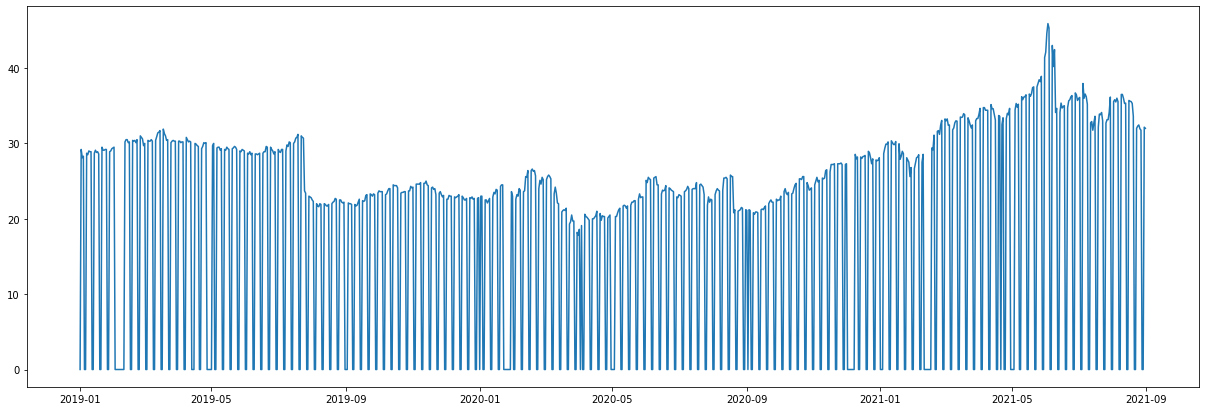

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#Visualize data
plt.figure(figsize=(21, 7))
plt.plot(train_set['close'])

Có thể thấy chuỗi tăng giảm không ổn định cho lắm. Tuy nhiên cần kiểm chứng chắc chắn hơn : 

*   Phân tách chuỗi thành các thành phần
*   Thực hiện kiểm tra ADF

Phân tích chuỗi thành **3 thành phần** : xu hướng (**trend**), thời vụ (**seasonality**) và còn lại (**residual**)

In [ ]:
import seaborn as sns
import statsmodels.api as sm
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

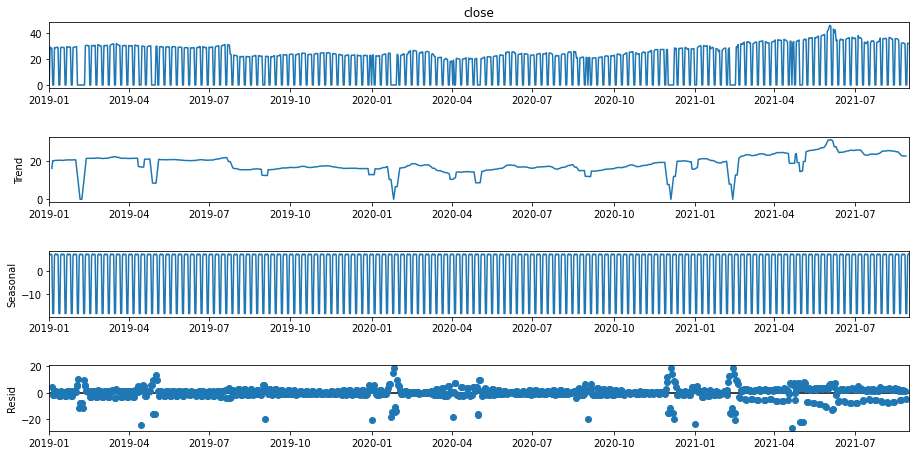

In [ ]:
decomp = seasonal_decompose(train_set['close'])
fig = decomp.plot()
fig.set_size_inches(14, 7)

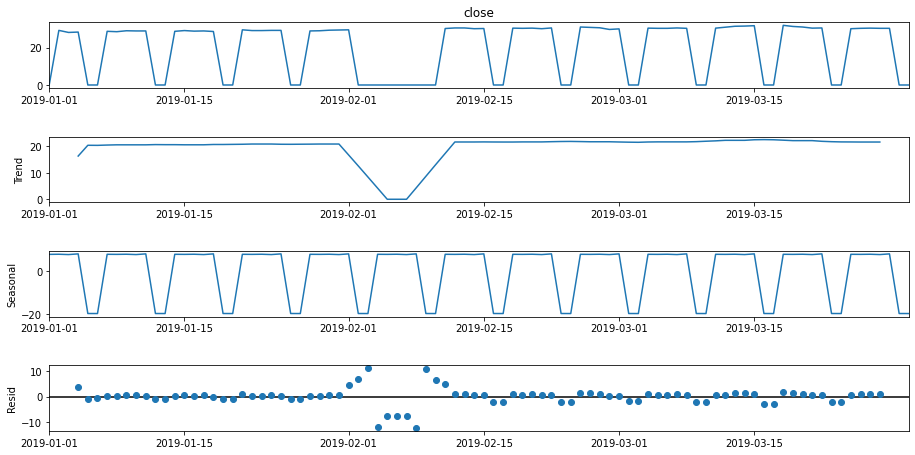

In [ ]:
#Vẽ 3 tháng đầu
decomp = seasonal_decompose(train_set['close'][:90])
fig = decomp.plot()
fig.set_size_inches(14, 7)

Có thể thấy từ 2 biểu đồ trên, chuỗi có vẻ có xu hướng tăng và có tính thời vụ theo tuần. Tuy nhiên cần kiểm chứng cụ thể hơn và bỏ tính thời vụ của chuỗi

Kiểm tra tính ổn định bằng giả thuyết **Augmented Dickey-Fuller Test**

In [ ]:
from statsmodels.tsa.stattools import adfuller

fuller_test = adfuller(train_set['close'])

print('ADF Statistic: %f' % fuller_test[0])
print('p-value: %f' % fuller_test[1])

ADF Statistic: -3.340369
p-value: 0.013168


Do giá trị p-value < 0.05 nên chuỗi ổn định

In [ ]:
#Định nghĩa 1 hàm kiểm tra tính ổn định của chuỗi
def test_p_value(data):
  fuller_test = adfuller(data)
  print('p-value : %.5f' % fuller_test[1])
  if(fuller_test[1] <= 0.05):
    print('Chuỗi ổn định')
  else:
    print('Chuỗi KHÔNG ổn định')

In [ ]:
#test
test_p_value(train_set['close'])

p-value : 0.01317
Chuỗi ổn định


Để bỏ tính thời vụ của chuỗi cũng như để chuỗi ổn định, ta áp dụng Difference. Ở đây, áp dụng **Seasonal Differencing**

In [59]:
train_set['Seasonal_diff'] = train_set['close'] - train_set['close'].shift(7)

train_set.head(10)

,close,Seasonal_diff
2019-01-01,0.0,NaN
2019-01-02,29.2,NaN
2019-01-03,28.1,NaN
2019-01-04,28.3,NaN
2019-01-05,0.0,NaN
2019-01-06,0.0,NaN
2019-01-07,28.7,NaN
2019-01-08,28.5,28.5
2019-01-09,29.0,-0.2
2019-01-10,28.9,0.8


p-value : 0.00000
Chuỗi ổn định


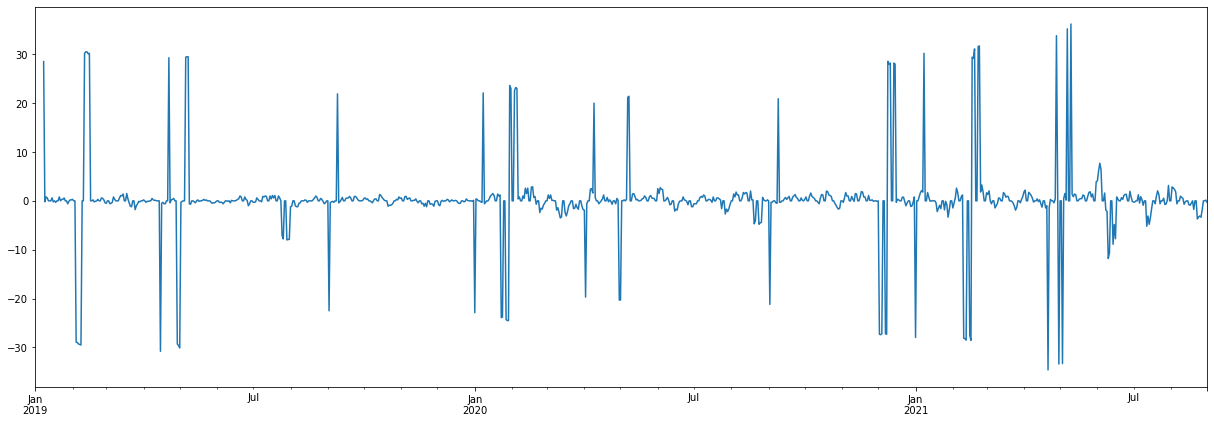

In [62]:
#Seasonal Difference
plt.figure(figsize=[21,7])
train_set['Seasonal_diff'].plot()
#train_set['Seasonal_diff'][91:121].plot()

#Xác định tính ổn định của chuỗi
test_p_value(train_set['Seasonal_diff'].dropna())

Có thể thấy chuỗi đã không còn tính thời vụ theo tuần

# **Xây dựng model SARIMA**

**Chọn bộ tham số SARIMA(p,d,q)x(P,D,Q,s)**

Ta thực hiện theo 2 bước :

1.   Chọn bộ số khởi tạo ban đầu
2.   Tìm kiếm lưới để tìm bộ số tối ưu cho model

Vì chuỗi ổn định nên không cần áp dụng Difference => d = 0
Do đã áp dụng Seasonal Differencing 1 lần nên D = 1
Chọn p,q khởi tạo bằng cách áp dụng biểu đồ ACF (chọn q, Q) và PACF (chọn p, P)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


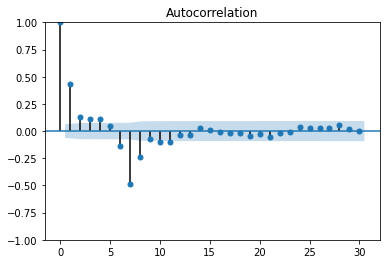

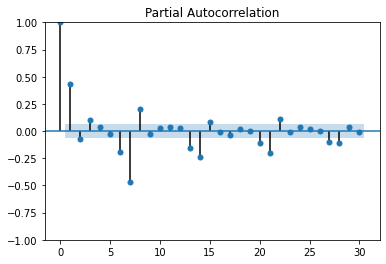

In [63]:
#Vẽ ACF và PACF
q_para = plot_acf(train_set['Seasonal_diff'].dropna())

p_para = plot_pacf(train_set['Seasonal_diff'].dropna())

Qua 2 biểu đồ trên, nhận thấy : 

*   **PACF** có mức tăng đột biến âm đáng kể tại các vị trí **lag(độ trễ) 7, 14, 21**,... (đây là suy giảm cấp mũ _ *expotential decay*) ; và bên cạnh đó ở biểu đồ **ACF** có mức tăng đột biến âm đáng kể tại **lag 7**, qua đó cho thấy giá trị **Q = 1** (thể hiện tính thời vụ theo tuần) và giá trị **P = 0**
*   **PACF** và **ACF** đều có mức tăng đột biến dương đáng kể tại **lag 1** nên **p = q = 1**
*   Vì có vị trí lag tương ứng là 7,14,21,... nên **s = 7** (tính thời vụ theo tuần)

==> Ta có bộ tham số khởi tạo ban đầu : **SARIMA(1,0,1)x(0,1,1,7)**





**Mô hình SARIMA sơ bộ**

*   Triển khai mô hình SARIMA sơ bộ sử dụng các thông số xác định từ các ô ACF và PACF.
*   Kiểm tra chất lượng của mô hình bằng các đồ thị ACF và PACF mới về phần còn lại của mô hình (*model's residuals*).

In [66]:
# fit SARIMA dựa trên tham số khởi tạo
sar = sm.tsa.statespace.SARIMAX(train_set['close'], 
                                order=(1,0,1), 
                                seasonal_order=(0,1,1,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/optimizer.py:23: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method powell is: xtol, ftol, maxfun, start_direc. The list of unsupported keyword arguments passed include: max_iter. After release 0.14, this will raise.
  FutureWarning


Optimization terminated successfully.
         Current function value: 3.008239
         Iterations: 4
         Function evaluations: 188


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                  974
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -2930.025
Date:                           Fri, 15 Oct 2021   AIC                           5868.050
Time:                                   04:19:30   BIC                           5887.547
Sample:                               01-01-2019   HQIC                          5875.472
                                    - 08-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4584      0.035     13.004      0.000       0.389       0.527
ma.L1          0.0734      0.043      1.690      0.091      -0.012       0.159
ma.S.L7       -0.8948      0.014    -66.001      0.000      -0.921      -0.868
sigma2        24.7227      0.469     52.738      0.000      23.804      25.641
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):              9575.08
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


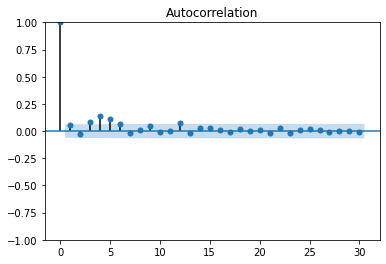

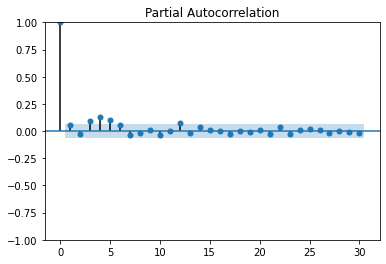

In [67]:
#Kiểm tra chất lượng qua residual
res = sar.resid

f1 = plot_acf(res.dropna())

f2 = plot_pacf(res.dropna())

Có thể thấy đã hầu như không còn các đột biến đáng kể tại ở cả 2 biểu đồ ACF và PACF nên bộ tham số **(1,0,1)x(0,1,1,7)** có thể chấp nhận làm bộ tham số khởi tạo để tìm kiếm lưới

**Grid Search**

In [68]:
#Grid search bằng thư viện có sẵn 
from pmdarima import auto_arima
  
#Ignore harmless warnings
warnings.filterwarnings("ignore")
  
#Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(train_set['close'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 7,
                          start_P = 0, start_Q = 1,
                          max_P = 3, max_Q = 3, seasonal = True,
                          d = 0, D = 1, trace = True,
                          error_action ='ignore')           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=5868.164, Time=1.74 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=6648.859, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=6145.143, Time=1.10 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=5903.534, Time=0.90 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=6646.898, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=6438.476, Time=0.47 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=5868.451, Time=1.78 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=5868.509, Time=3.15 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=6142.268, Time=1.32 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=5865.237, Time=5.48 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=5867.237, Time=7.73 sec
 ARIMA(1,0,1)(1,1,3)[7] intercept   : AIC=5867.237, Time=10.10 sec
 ARIMA(1,0,1)(0,1,3)[7] intercept   : AIC=5870.313, Time=5.36 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=5870.208, Time=3.90 sec
 ARIMA(1,0,1)(2,1,3)[7] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  974
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2], 7)   Log Likelihood               -2926.552
Date:                                Fri, 15 Oct 2021   AIC                           5863.103
Time:                                        04:27:06   BIC                           5887.474
Sample:                                             0   HQIC                          5872.381
                                                - 974                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5155      0.012     42.453      0.000       0.492       0.539
ar.S.L7       -0.9076      0.060    -15.152      0.000      -1.025      -0.790
ma.S.L7       -0.0181      0.067     -0.271      0.786      -0.149       0.113
ma.S.L14      -0.7753      0.066    -11.689      0.000      -0.905      -0.645
sigma2        24.6023      0.489     50.282      0.000      23.643      25.561
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              9485.03
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -2.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
#Grid search tay
# SETUP (using itertools to gridsearch solutions)
import itertools

# set parameter range
p = range(1,3)
q = range(0,3)
d = range(0,2)
s = range(7,8)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = list(itertools.product(p, d, q, s))

In [72]:
seasonal_pdq

[(1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 0, 2, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (2, 0, 0, 7),
 (2, 0, 1, 7),
 (2, 0, 2, 7),
 (2, 1, 0, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7)]

In [73]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_set['close'],
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 3.314545
         Iterations: 3
         Function evaluations: 110
SARIMA(1, 0, 0),(1, 0, 0, 7)7 - AIC:6462.734093788955
Optimization terminated successfully.
         Current function value: 3.038794
         Iterations: 6
         Function evaluations: 297
SARIMA(1, 0, 0),(1, 0, 1, 7)7 - AIC:5927.571084837
Optimization terminated successfully.
         Current function value: 3.037753
         Iterations: 5
         Function evaluations: 303
SARIMA(1, 0, 0),(1, 0, 2, 7)7 - AIC:5927.5434762892855
Optimization terminated successfully.
         Current function value: 3.150514
         Iterations: 2
         Function evaluations: 72
SARIMA(1, 0, 0),(1, 1, 0, 7)7 - AIC:6143.202230883742
Optimization terminated successfully.
         Current function value: 3.007264
         Iterations: 4
         Function evaluations: 194
SARIMA(1, 0, 0),(1, 1, 1, 7)7 - AIC:5866.150152598331
Optimization terminated successfully.
     

Thực hiện tìm kiếm tự động, bộ tham số tốt nhất cho mô hình là **SARIMA(1,0,0)x(1,1,2,7)** vì có chỉ số AIC thấp nhất (Cần tối ưu lại tham số cho tool tự động)

Sau khi thực hiện tìm kiếm, bộ tham số tốt nhất cho mô hình là **SARIMA(1,0,2)x(2,1,2,7)** vì có chỉ số AIC thấp nhất ==> **Chọn bộ này**

In [76]:
# fit SARIMA 
sar = sm.tsa.statespace.SARIMAX(train_set['close'], 
                                order=(1,0,2), 
                                seasonal_order=(2,1,2,7)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             close   No. Observations:                  974
Model:             SARIMAX(1, 0, 2)x(2, 1, 2, 7)   Log Likelihood               -2913.044
Date:                           Fri, 15 Oct 2021   AIC                           5842.087
Time:                                   04:42:38   BIC                           5881.081
Sample:                               01-01-2019   HQIC                          5856.932
                                    - 08-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8707      0.036     23.992      0.000       0.800       0.942
ma.L1         -0.3570      0.042     -8.595      0.000      -0.438      -0.276
ma.L2         -0.2514      0.031     -8.007      0.000      -0.313      -0.190
ar.S.L7       -0.9413      0.090    -10.476      0.000      -1.117      -0.765
ar.S.L14      -0.0275      0.039     -0.699      0.485      -0.105       0.050
ma.S.L7       -0.0237      0.082     -0.288      0.773      -0.185       0.138
ma.S.L14      -0.7848      0.072    -10.963      0.000      -0.925      -0.645
sigma2        23.9149      0.488     49.054      0.000      22.959      24.870
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              8676.78
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -2.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

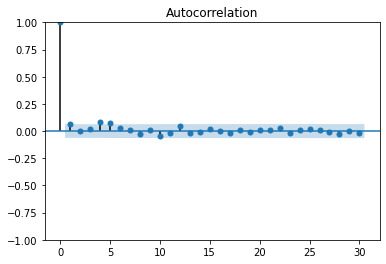

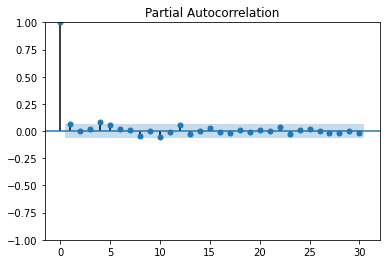

In [79]:
#Kiểm tra chất lượng qua residual
res = sar.resid

f1 = plot_acf(res.dropna())

f2 = plot_pacf(res.dropna())

**Walk Forward Validation**

In [86]:
train = train_set['close'].squeeze().values

train

array([ 0.  , 29.2 , 28.1 , 28.3 ,  0.  ,  0.  , 28.7 , 28.5 , 29.  ,
       28.9 , 28.9 ,  0.  ,  0.  , 28.7 , 29.1 , 28.8 , 28.9 , 28.6 ,
        0.  ,  0.  , 29.5 , 29.1 , 29.1 , 29.2 , 29.2 ,  0.  ,  0.  ,
       28.9 , 29.  , 29.3 , 29.4 , 29.5 ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  , 30.2 , 30.5 , 30.5 , 30.1 ,
       30.2 ,  0.  ,  0.  , 30.4 , 30.3 , 30.4 , 30.1 , 30.5 ,  0.  ,
        0.  , 31.  , 30.8 , 30.6 , 29.7 , 30.  ,  0.  ,  0.  , 30.4 ,
       30.3 , 30.3 , 30.5 , 30.3 ,  0.  ,  0.  , 30.4 , 30.9 , 31.4 ,
       31.5 , 31.7 ,  0.  ,  0.  , 31.9 , 31.3 , 31.  , 30.4 , 30.5 ,
        0.  ,  0.  , 30.1 , 30.3 , 30.4 , 30.3 , 30.3 ,  0.  ,  0.  ,
       30.3 , 30.3 , 30.1 , 30.2 , 30.2 ,  0.  ,  0.  , 30.8 , 30.5 ,
       30.2 , 30.3 , 30.2 ,  0.  ,  0.  ,  0.  , 30.  , 29.9 , 29.7 ,
       29.6 ,  0.  ,  0.  , 29.3 , 29.6 , 30.1 , 30.  , 30.1 ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  , 29.7 , 30.  ,  0.  ,  0.  , 29.4 ,
       29.5 , 29.5 ,

In [87]:
test = test_set['close'].squeeze().values

test

array([32.  ,  0.  ,  0.  ,  0.  ,  0.  , 32.05, 32.5 , 32.15, 32.45,
       32.3 ,  0.  ,  0.  , 31.9 , 31.5 , 31.2 , 31.3 , 31.6 ,  0.  ,
        0.  , 32.1 , 31.8 , 31.6 , 31.6 , 32.  ,  0.  ,  0.  , 31.5 ,
       31.6 , 31.35, 31.55, 31.5 ])

In [88]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in train]
predictions = list()
residuals = list()

# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(endog=history,order=(1,0,2),seasonal_order=(2,1,2,7),trend='c',enforce_invertibility=False)
    model_fit = model.fit(maxiter=1000)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    residuals.append(yhat-obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
model = SARIMAX(endog=history,order=(1,0,2),seasonal_order=(2,1,2,7),trend='c',enforce_invertibility=False)
model_fit = model.fit(maxiter=1000)

predicted=33.185257, expected=32.000000
predicted=33.397019, expected=0.000000
predicted=15.635872, expected=0.000000
predicted=-15.479938, expected=0.000000
predicted=-0.841779, expected=0.000000
predicted=28.922906, expected=32.050000
predicted=31.875603, expected=32.500000
predicted=31.034290, expected=32.150000
predicted=31.064839, expected=32.450000
predicted=31.377376, expected=32.300000
predicted=-0.680919, expected=0.000000
predicted=-0.419441, expected=0.000000
predicted=33.347064, expected=31.900000
predicted=33.017773, expected=31.500000
predicted=32.588804, expected=31.200000
predicted=28.652746, expected=31.300000
predicted=29.829122, expected=31.600000
predicted=0.825165, expected=0.000000
predicted=-0.149327, expected=0.000000
predicted=33.276747, expected=32.100000
predicted=33.397813, expected=31.800000
predicted=32.383780, expected=31.600000
predicted=31.438698, expected=31.600000
predicted=31.503024, expected=32.000000
predicted=0.102987, expected=0.000000
predicted=

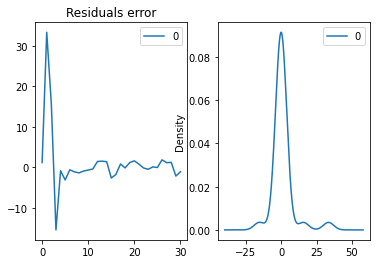

In [89]:
fig, axes = plt.subplots(1, 2)

residuals = pd.DataFrame(residuals)
residuals.plot(ax=axes[0])
axes[0].set_title('Residuals error')

residuals.plot(kind='kde', ax=axes[1])

plt.show()

In [90]:
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.297


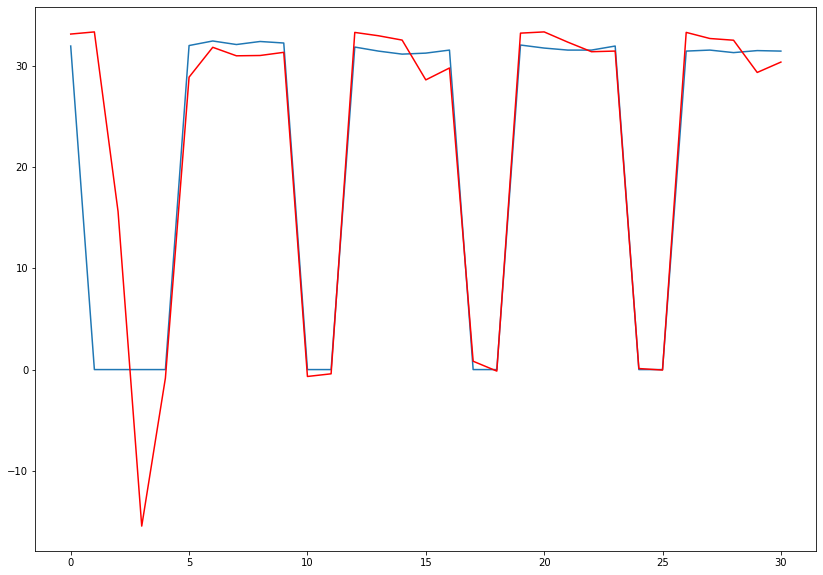

In [93]:
plt.figure(figsize=(14, 10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [92]:
y = model_fit.predict(1,7)
print(y)

[0.03876269 0.03954488 0.03976087 0.03991959 0.03923958 0.0390044
 0.0392976 ]
